In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import io
import requests
import re
import warnings
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-notebook')
from matplotlib.ticker import StrMethodFormatter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
#I used plotly and sns for the visuals

## **Acquire data**

In [29]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [30]:
train = pd.read_csv("/content/drive/MyDrive/For Path Forward Students/Class Projects/titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/For Path Forward Students/Class Projects/titanic/test.csv")
temp = pd.concat([train,test],keys=[0,1])
temp.head()

PassengerId  Survived  Pclass  \
0 0            1       0.0       3   
  1            2       1.0       1   
  2            3       1.0       3   
  3            4       1.0       1   
  4            5       0.0       3   

                                                  Name     Sex   Age  SibSp  \
0 0                            Braund, Mr. Owen Harris    male  22.0      1   
  1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
  2                             Heikkinen, Miss. Laina  female  26.0      0   
  3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
  4                           Allen, Mr. William Henry    male  35.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0 0      0         A/5 21171   7.2500   NaN        S  
  1      0          PC 17599  71.2833   C85        C  
  2      0  STON/O2. 3101282   7.9250   NaN        S  
  3      0            113803  53.1000  C123        S  
  4      0            373450   8.0500   NaN        S

## **Analyze by describing data**

Pandas helps describe the datasets answering following questions early in our project.

Which features are available in the dataset?

Which features are categorical? Within categorical features are the values nominal, ordinal, ratio, or interval based?

Which features are numerical? Within numerical features are the values discrete, continuous, or timeseries based?

Which features are mixed data types? Numerical, alphanumeric data within same feature. These are candidates for correcting goal.

Which features may contain errors or typos? These will require correcting.

Which features contain blank, null or empty values? These will require correcting.

What are the data types for various features?

In [31]:
print(temp.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [32]:
print('Train columns:', train.columns.tolist())

Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [33]:
print('Test columns:', test.columns.tolist())

Test columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [34]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (0, 0) to (1, 417)
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 165.9+ KB


In [35]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

What is the distribution of numerical feature values across the samples?

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


What is the distribution of categorical features?

In [12]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## Outlier detection

In [13]:
from collections import Counter
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
        
    return multiple_outliers 

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

Since outliers can have a dramatic effect on the prediction (espacially for regression problems), i choosed to manage them.

I used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

I decided to detect outliers from the numerical values features (Age, SibSp, Sarch and Fare). Then, i considered outliers as rows that have at least two outlied numerical values.


In [14]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [ ]:
# We detect 10 outliers. The passengers with IDs 28, 89 and 342 have high Ticket Fare.

# The 7 others have very high values of SibSP.

# Drop outliers
# train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


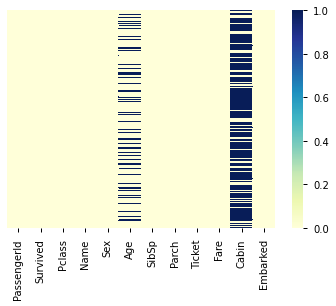

In [15]:
sns.heatmap(train.isnull(), yticklabels = False, cmap="YlGnBu")

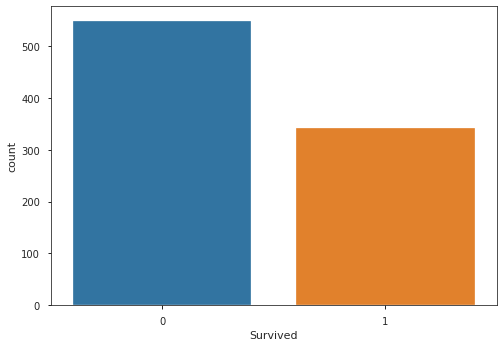

In [ ]:
sns.set_style('ticks')
sns.countplot(x='Survived', data = train)

# **Correlation**

We want to know how each feature is correlated with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

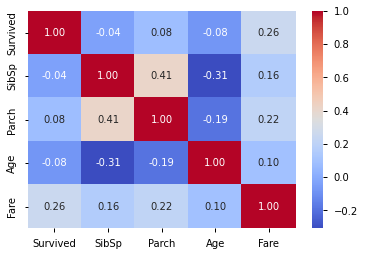

In [17]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

#Only Fare feature seems to have a significative correlation with the survival probability.
#It doesn't mean that the other features are not usefull. 
#Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features


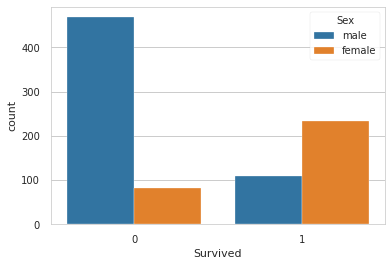

In [18]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Sex', data=train)

In [37]:
women = train.loc[train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)
print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [20]:
men = train.loc[train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)
print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [21]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


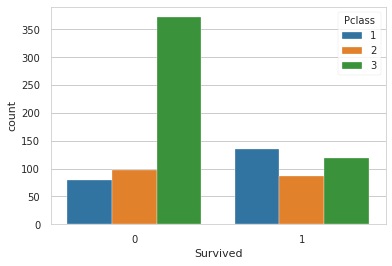

In [22]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Pclass', data=train)

In [23]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


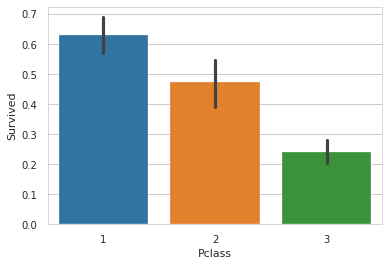

In [24]:
sns.barplot(x='Pclass', y='Survived', data=train);

In [25]:
for template in ["plotly"]:
    fig = px.scatter(train,
                     x="PassengerId", y="Age", color="Survived",
                     log_x=True, size_max=20,
                     template=template, title="Which Age Survived?")
    fig.show()

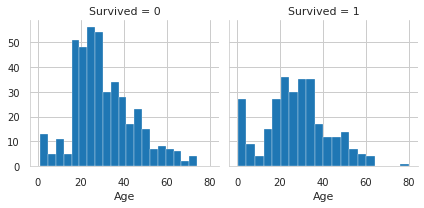

In [38]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

#**Analyze by visualizing data**

Now we can continue confirming some of our assumptions using visualizations for analyzing the data.
Correlating numerical features

Let us start by understanding correlations between numerical features and our solution goal (Survived).

A histogram chart is useful for analyzing continous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)

Note that x-axis in historgram visualizations represents the count of samples or passengers.

Observations.

Infants (Age <=4) had high survival rate.
Oldest passengers (Age = 80) survived.
Large number of 15-25 year olds did not survive.
Most passengers are in 15-35 age range.

Decisions.

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

We should consider Age (our assumption classifying #2) in our model training.
Complete the Age feature for null values (completing #1).
We should band age groups (creating #3).

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



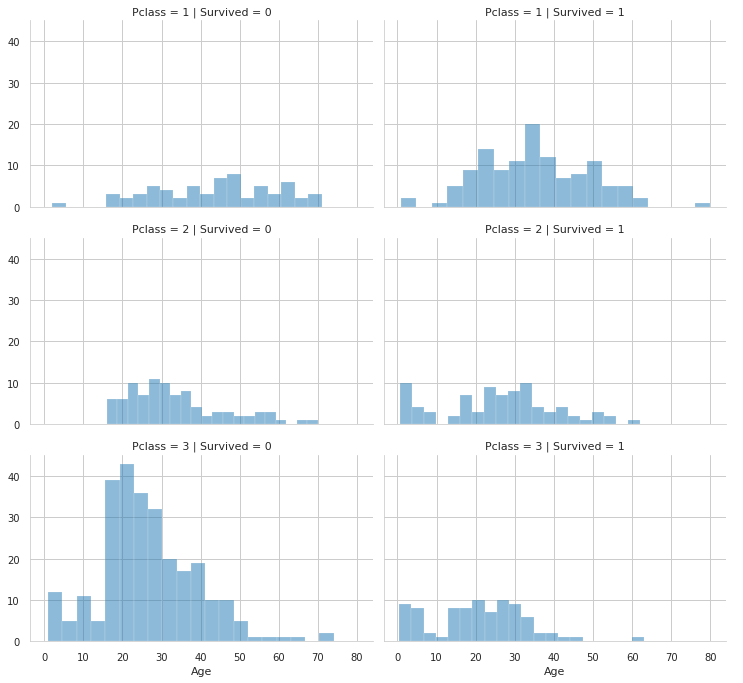

In [ ]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', size=3.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

# **Correlating numerical and ordinal features**

We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values.

Observations.

Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.

Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.

Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.

Pclass varies in terms of Age distribution of passengers.

Decisions.

Consider Pclass for model training.



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



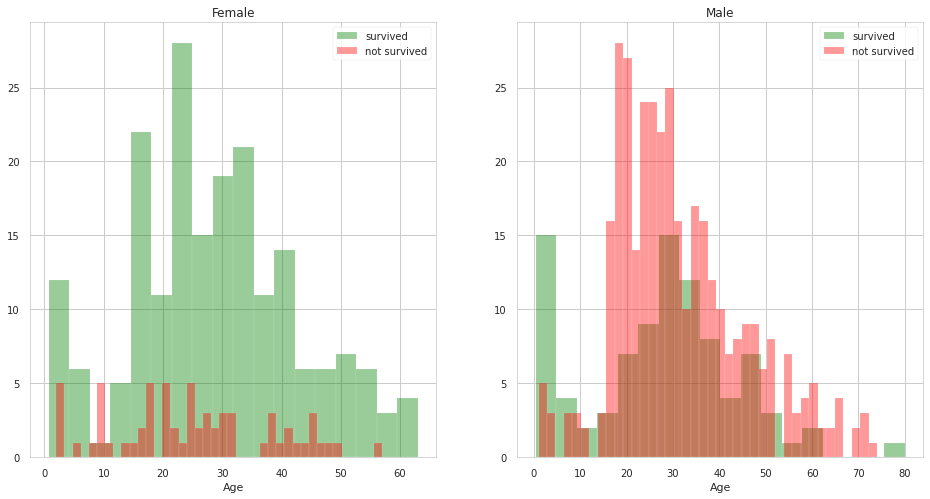

In [27]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
women = train[train['Sex']=='female']
men = train[train['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False, color="green")
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False, color="green")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend()
_ = ax.set_title('Male');

# **Correlating categorical features**

Now we can correlate categorical features with our solution goal.

Observations.

Female passengers had much better survival rate than males. Confirms classifying (#1).

Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.

Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).

Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

Decisions.

Add Sex feature to model training.

Complete and add Embarked feature to model training.

In [40]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



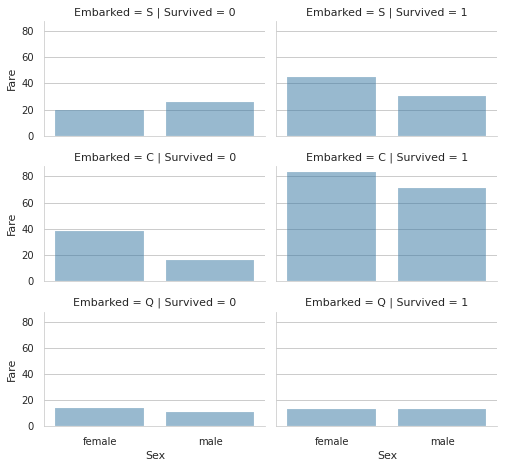

In [ ]:
grid = sns.FacetGrid(train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# **Correlating categorical and numerical features**

We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric).

Observations.

Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.

Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

Decisions.

Consider banding Fare feature.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



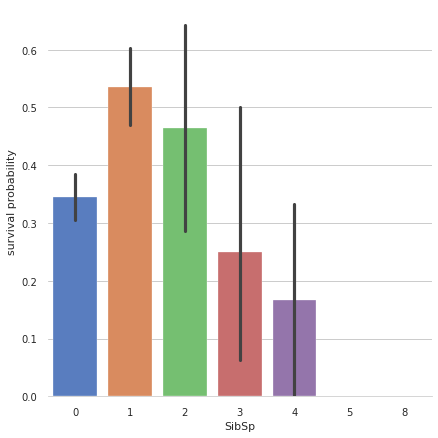

In [ ]:
#sns.set_style('whitegrid')
#sns.countplot(x='SibSp', data=train)

# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 ,  palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive

Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)


In [ ]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



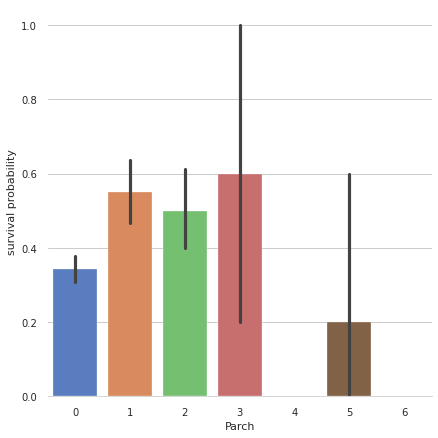

In [ ]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children


In [ ]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



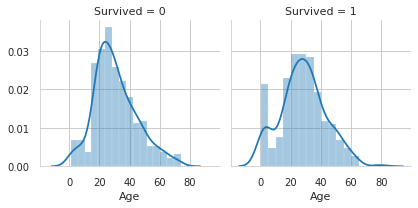

In [ ]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.

So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.

It seems that very young passengers have more chance to survive.


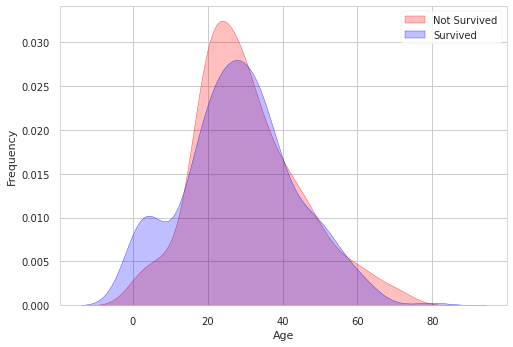

In [ ]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.

In [ ]:
import plotly.express as px
temp0 = train.groupby(by="Cabin").count()
name = temp0.Survived.index
val = temp0.Survived.values

fig = px.scatter_polar(temp0, r=val, theta=name,color=name, symbol=val, 
                       size=val,color_discrete_sequence=px.colors.sequential.Plasma_r, title='Survived by Cabin')
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



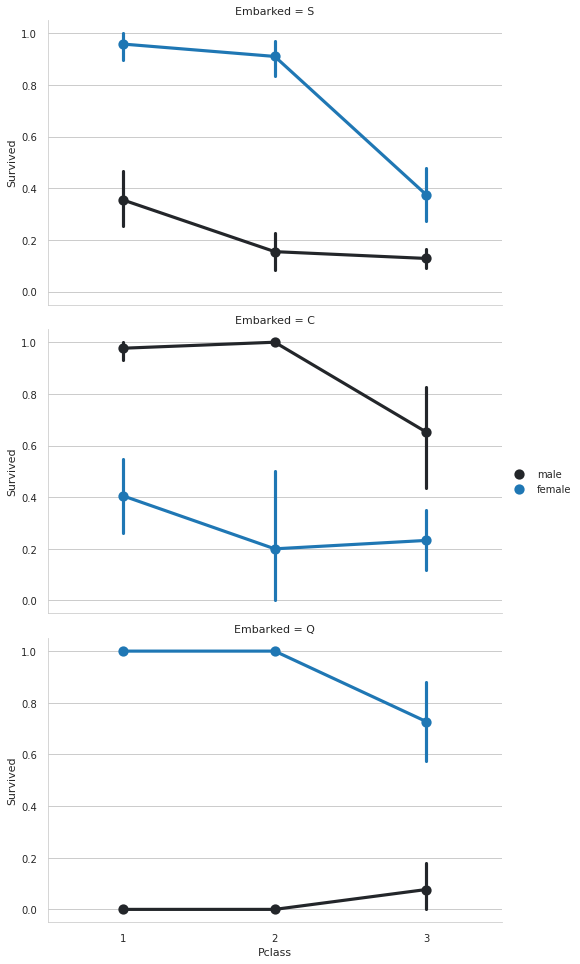

In [ ]:
FacetGrid = sns.FacetGrid(train, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None )
FacetGrid.add_legend();

In [ ]:
t0 = train.iloc[(train["Survived"]==0).values]
t1 = train.iloc[(train["Survived"]==1).values]

temp0 = t0.groupby(by="Embarked").count()
name0 = temp0.Survived.index
val0 = temp0.Survived.values

temp1 = t1.groupby(by="Embarked").count()
name1 = temp1.Survived.index
val1 = temp1.Survived.values

fig = px.scatter_polar(r=val1+val0, theta=name1,color=np.round(val1/(val0+val1)*100,0), 
                       symbol=val0, size=np.round(val1/(val0+val1)*100,0),
                       color_discrete_sequence=px.colors.sequential.Plasma_r, title='Survived by Embarked')
fig.show()

# **Correcting.**

Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.

Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.

PassengerId may be dropped from training dataset as it does not contribute to survival.

Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

# **Completing.**

We may want to complete Age feature as it is definitely correlated to survival.

We may want to complete the Embarked feature as it may also correlate with survival or another important feature.


In [ ]:
em_mode=temp['Embarked'].mode()   #The mode of a set of data values is the value that appears most often. 
temp['Embarked'] = temp['Embarked'].fillna(em_mode)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



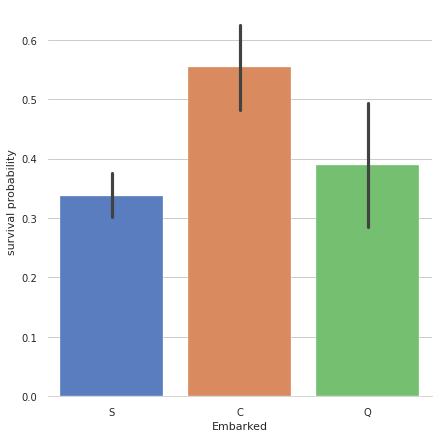

In [ ]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

# **Converting a categorical feature**

Now we can convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal.

In [ ]:
temp["Cabin_B"] = temp["Cabin"].factorize()[0]  #codes, uniques = pd.factorize(['b', 'b', 'a', 'c', 'b'])     codes=array([0, 0, 1, 2, 0]...)
temp['Deck'] = temp['Cabin'].str[:1]
temp['Deck_B'] = temp["Deck"].factorize()[0]
temp['Embarked_B'] = temp['Embarked'].factorize()[0]
temp["Sex_B"] = temp["Sex"].factorize()[0]
temp["Sex_B"] = temp["Sex_B"] + 1
temp["Cabin_B"] = temp["Cabin_B"] + 1
temp["Deck_B"] = temp["Deck_B"] + 1
temp["Embarked_B"] = temp["Embarked_B"] + 1
temp.head()

PassengerId  Survived  Pclass  ... Deck_B Embarked_B  Sex_B
0 0            1       0.0       3  ...      0          1      1
  1            2       1.0       1  ...      1          2      2
  2            3       1.0       3  ...      0          1      2
  3            4       1.0       1  ...      1          1      2
  4            5       0.0       3  ...      0          1      1

[5 rows x 17 columns]

# **Completing a numerical continuous feature**

Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

To adress this problem, i looked at the most correlated features with Age (Sex, Parch , Pclass and SibSP).

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py

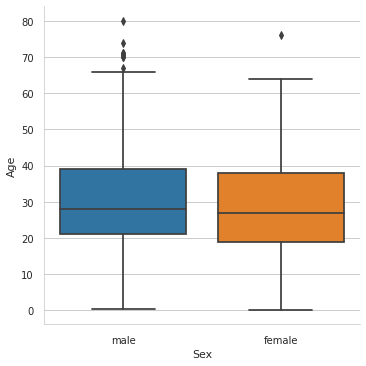

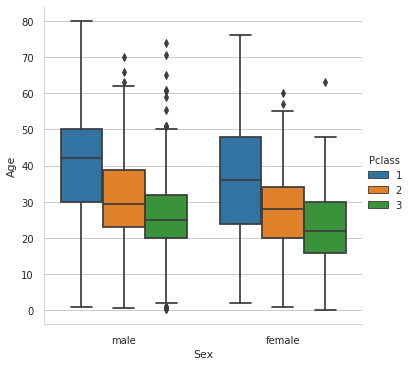

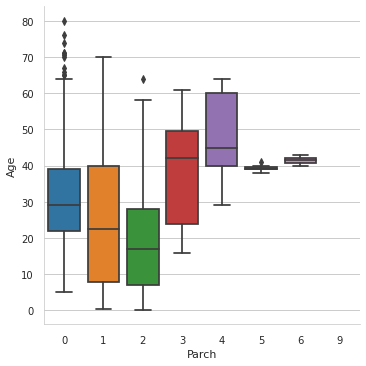

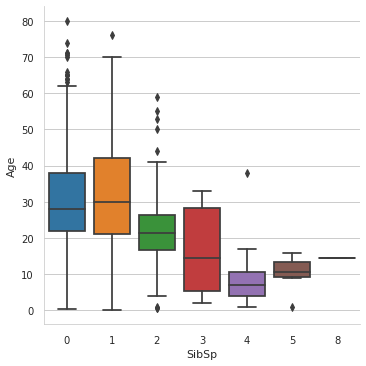

In [ ]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=temp,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=temp,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=temp,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=temp,kind="box")

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.


It seems that passenger coming from Cherbourg (C) have more chance to survive.

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).


We can consider three methods to complete a numerical continuous feature.

1 A simple way is to generate random numbers between mean and standard deviation.

2 More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

3 Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will prefer method 2.

In [ ]:
'''
Method 1

mean = temp["Age"].mean()
std = temp["Age"].std()
is_null = temp["Age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
# fill NaN values in Age column with random values generated
age_slice = temp["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
temp["Age"] = age_slice
temp["Age"] = temp["Age"].astype(int)
'''

'\nMethod 1\n\nmean = temp["Age"].mean()\nstd = temp["Age"].std()\nis_null = temp["Age"].isnull().sum()\n# compute random numbers between the mean, std and is_null\nrand_age = np.random.randint(mean - std, mean + std, size = is_null)\n# fill NaN values in Age column with random values generated\nage_slice = temp["Age"].copy()\nage_slice[np.isnan(age_slice)] = rand_age\ntemp["Age"] = age_slice\ntemp["Age"] = temp["Age"].astype(int)\n'

In [ ]:
#Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.
guess_ages = np.zeros((2,3))
#Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.
for i in range(0, 2):
        for j in range(0, 3):
            guess_df = temp[(temp['Sex_B'] == i+1) & (temp['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_df.median()
            guess_ages[i,j] = int(age_guess/0.5 + 0.5 ) * 0.5
for i in range(0, 2):
        for j in range(0, 3):
            temp.loc[ (temp.Age.isnull()) & (temp.Sex_B == i+1) & (temp.Pclass == j+1),'Age'] = guess_ages[i,j]

temp['Age'] = temp['Age'].astype(int)

#Let us create Age bands and determine correlations with Survived.
temp['AgeBand'] = pd.cut(temp['Age'], 5)
temp[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [ ]:
temp['AgeBand'] = temp['AgeBand'].factorize()[0]
temp["AgeBand"] = temp["AgeBand"] + 1

# **Creating.**

We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.

We may want to engineer the Name feature to extract Title as a new feature.

We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.

We may also want to create a Fare range feature if it helps our analysis.


**Create new feature combining existing features**

We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.


In [ ]:
temp['FamilySize'] = temp['SibSp'] + temp['Parch']+1
temp[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000



# **Quick completing and converting a numeric feature**

We can now complete the Fare feature for single missing value in test dataset using mode to get the value that occurs most frequently for this feature. We do this in a single line of code.

Note that we are not creating an intermediate new feature or doing any further analysis for correlation to guess missing feature as we are replacing only a single value. The completion goal achieves desired requirement for model algorithm to operate on non-null values.

We may also want round off the fare to two decimals as it represents currency.

In [ ]:
temp['Fare'].fillna(temp['Fare'].dropna().median(),inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



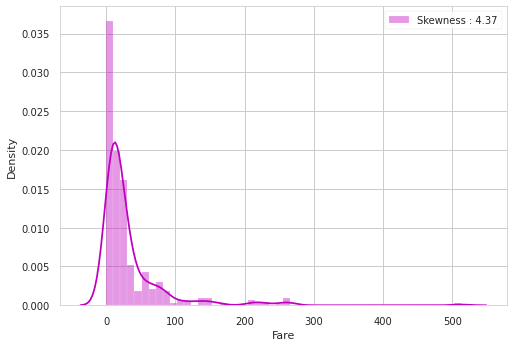

In [ ]:
# Explore Fare distribution 
g = sns.distplot(temp["Fare"], color="m", label="Skewness : %.2f"%(temp["Fare"].skew()))
g = g.legend(loc="best")

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

In [ ]:
# Apply log to Fare to reduce skewness distribution
temp["Fare"] = temp["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



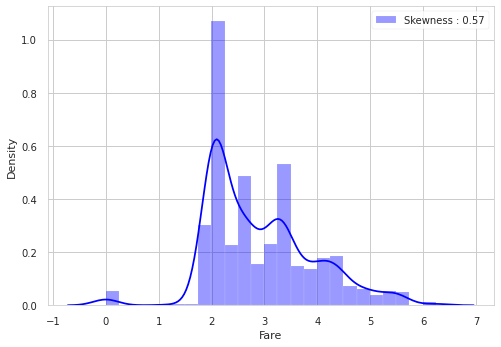

In [ ]:
g = sns.distplot(temp["Fare"], color="b", label="Skewness : %.2f"%(temp["Fare"].skew()))
g = g.legend(loc="best")

In [ ]:
temp['FareBand'] = pd.qcut(temp['Fare'], 4)
temp[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197309
1,"(7.896, 14.454]",0.303571
2,"(14.454, 31.275]",0.441048
3,"(31.275, 512.329]",0.600000


In [ ]:
temp['FareBand']=temp['FareBand'].factorize()[0]
temp['FareBand'] = temp['FareBand']+1

In [ ]:
temp.head()

PassengerId  Survived  Pclass  ... AgeBand FamilySize  FareBand
0 0            1       0.0       3  ...       1          2         1
  1            2       1.0       1  ...       2          2         2
  2            3       1.0       3  ...       1          1         3
  3            4       1.0       1  ...       2          2         2
  4            5       0.0       3  ...       2          1         3

[5 rows x 20 columns]

In [ ]:
temp['Title'] = temp['Name'].apply(lambda x: x.split(",")[1].split(".")[0])
pd.crosstab(temp['Title'], temp['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,61


We can replace many titles with a more common name or classify them as Rare.

In [ ]:
temp['Title'] = temp['Title'].replace(['Lady', 'the Countess','Capt', 'Col', 'Dona', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Don'], 'Rare', regex=True)
temp['Title'] = temp['Title'].replace('Mlle','Miss', regex=True)
temp['Title'] = temp['Title'].replace('Ms', 'Miss', regex=True )
temp['Title'] = temp['Title'].replace('Mme', 'Mrs', regex=True )

#temp['Title'].factorize()[1]
temp[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


We can convert the categorical titles to ordinal.

In [ ]:
#title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
#temp['Title_B'] = temp['Title'].map(title_mapping)
#temp['Title_B'] = temp['Title_B'].fillna(0)
temp['Title_B'] = temp["Title"].factorize()[0]
temp['Title_B'] = temp["Title_B"]+1

In [ ]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (0, 0) to (1, 417)
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   int64  
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Cabin_B      1309 non-null   int64  
 13  Deck         295 non-null    object 
 14  Deck_B       1309 non-null   int64  
 15  Embarked_B   1309 non-null   int64  
 16  Sex_B        1309 non-null   int64  
 17  AgeBand      1309 non-null   int64  
 18  FamilySize   1309 non-null   int64  
 1

In [ ]:
train,test = temp.xs(0),temp.xs(1)  

In [ ]:
train.head(5)    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_B,Deck,Deck_B,Embarked_B,Sex_B,AgeBand,FamilySize,FareBand,Title,Title_B
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,0,NaN,0,1,1,1,2,1,Mr,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,C,1,2,2,2,2,2,Mrs,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,NaN,0,1,2,1,1,3,Miss,3
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,2,C,1,1,2,2,2,2,Mrs,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,0,NaN,0,1,1,2,1,3,Mr,1


In [ ]:
test.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_B,Deck,Deck_B,Embarked_B,Sex_B,AgeBand,FamilySize,FareBand,Title,Title_B
0,892,NaN,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,NaN,Q,0,NaN,0,3,1,2,1,1,Mr,1
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,NaN,S,0,NaN,0,1,2,2,2,1,Mrs,2


In [ ]:
X_train = train[['Pclass','Title_B','Deck_B','Embarked_B','Sex_B','AgeBand','FareBand','FamilySize']]
y_train = train['Survived']
X_test = test[['Pclass','Title_B','Deck_B','Embarked_B','Sex_B','AgeBand','FareBand','FamilySize']]

# **Model, predict and solve**

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:
1 Logistic Regression

2 KNN or k-Nearest Neighbors

3 Support Vector Machines

4 Naive Bayes classifier

5 Decision Tree

6 Random Forrest

7 Perceptron

8 Artificial neural network

9 RVM or Relevance Vector Machine

# **Logistic Regression**

Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. Reference Wikipedia.

Note the confidence score generated by the model based on our training dataset.


In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_test = lr.predict(X_test)
acc_log = round(lr.score(X_train, y_train) * 100, 2)
acc_log

79.24

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

In [ ]:
train_df=pd.concat([X_train,y_train])
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(lr.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
4,FareBand,2.233299
1,Deck_B,0.381174
3,FamilySize,0.222276
2,Embarked_B,0.145911
6,Sex_B,0.127136
5,Pclass,0.038761
7,Title_B,-0.204102
0,AgeBand,-0.724516


# Support Vector Machine

Next we model using Support Vector Machines which are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference Wikipedia.

Note that the model generates a confidence score which is higher than Logistics Regression model.


In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

83.95

# **k-Nearest Neighbor**

In pattern recognition, the k-Nearest Neighbors algorithm (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. Reference Wikipedia.

KNN confidence score is better than Logistics Regression but worse than SVM.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

85.07

# **Naive Bayes**

In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference Wikipedia.

The model generated confidence score is the lowest among the models evaluated so far.

In [ ]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

79.12

# **Perceptron**

The perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. Reference Wikipedia.

In [ ]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

78.34

# **Linear SVC**

In [ ]:
from sklearn.svm import LinearSVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



79.57

# Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

71.27

# **Decision Tree**

This model uses a decision tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference Wikipedia.

The model confidence score is the highest among models evaluated so far.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

90.68

# **Random Forest**

The next model Random Forests is one of the most popular. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference Wikipedia.

The model confidence score is the highest among models evaluated so far. We decide to use this model's output (Y_pred) for creating our competition submission of results.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

90.68

# **Model evaluation**

We can now rank our evaluation of all the models to choose the best one for our problem. While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set.


In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,90.68
8,Decision Tree,90.68
1,KNN,85.07
0,Support Vector Machines,83.95
7,Linear SVC,79.57
2,Logistic Regression,79.24
4,Naive Bayes,79.12
5,Perceptron,78.34
6,Stochastic Gradient Decent,71.27


In [ ]:
submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':y_test})

#Visualize the first 5 rows
submission.head()

filename = 'Titanic Predictions 1.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: Titanic Predictions 1.csv
